# Data Science Master Class - czy firma zbankrutuje? 


Zadanie w ramach Data Science Master Class: Predykcja bankructwa firmy
    
Celem zadania było zbudować model, który prognozuje, czy dana firma zbankrutuje. 

Metryka sukcesu: F1

Konkurs był dostępny na Kaggle - link do  [konkursu](https://www.kaggle.com/t/87a15fd513a44bd1a92931177423c59f).

###  Wczytujemy biblioteki

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report


from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt

import matplotlib.pyplot as plt

### Dane

In [ ]:
df_train = pd.read_hdf("../input/train_taiwan.h5")
df_test = pd.read_hdf("../input/test_taiwan.h5")

df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all.columns = [x.replace(" ", "_").lower() for x in df_all.columns]

df_train.shape, df_test.shape, df_all.shape

((3409, 97), (3410, 96), (6819, 97))

#### Funkcja pomocnicza


In [ ]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3, black_list=["target"], show_feats=False, show_cr=False, show_cm=False, show_pr=False, show_lc=False):
    if feats is None:
        num_feats = df_all.select_dtypes("number").columns
        feats = [x for x in num_feats if x not in black_list]

    if show_feats:
        print(feats)
        
    df_train = df_all[ df_all["target"].notnull() ]
    X_train = df_train[feats].values
    y_train = df_train["target"].values

    scores = []
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        #y_pred = model.predict(X_train[test_idx])

        if show_cr:
            print(classification_report(y_train[test_idx], y_pred))
        
        if show_cm:
            skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred)#normalize=True
            
        if show_pr:
            skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)

    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=0)
    
    return eli5.show_weights(model, feature_names=feats, top=50)
    
    
def my_hist(df_all, feat_name, left_perc=1, right_perc=99):
    min_value = np.percentile( df_all[feat_name], 1)
    max_value = np.percentile( df_all[feat_name], 99)

    (
        df_all[ 
            (df_all[feat_name] > min_value) &
            (df_all[feat_name] < max_value)
        ][feat_name]
    ).hist(bins=100)
    plt.title("{}\n, left_perc={}, right_perc={}".format(feat_name, left_perc, right_perc))
    plt.show()
    
    
def save_result(filename, model, threshold=0.1):

    df_train = df_all[ df_all["target"].notnull() ]
    df_test = df_all[ df_all["target"].isnull() ].copy()

    num_feats = df_all.select_dtypes("number").columns
    feats = [x for x in num_feats if x not in ["target"]]

    
    model.fit(df_train[feats].values, df_train["target"].values)

    df_test["target"] = (model.predict_proba(df_test[feats].values)[:,1] > 0.1).astype(np.int)
    output_file = "../output/{}".format(filename)
    df_test[ ["id", "target"] ].to_csv(output_file, index=False)
    print("Saved: ", output_file)

Score:  0.4326876826876827 0.02803963590288893


Weight,Feature
0.0603,continuous_profit_rate_(after_tax)
0.0495,persistent_eps_in_the_last_four_seasons
0.0493,working_capital/equity
0.0486,roa(a)_after_tax_and_before_interest%
0.0420,"roa(b)_after_tax_and_before_interest,_before_depreciation"
0.0401,net_income_to_total_assets
0.0312,tax_rate_(a)
0.0244,total_debt/total_net_worth
0.0242,roa(c)_before_tax_and_interest_before_depreciation
0.0242,book_value_per_share_(b)


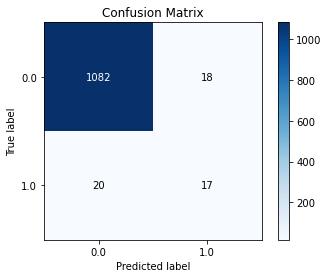

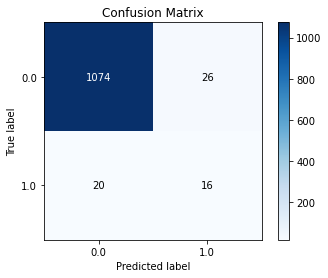

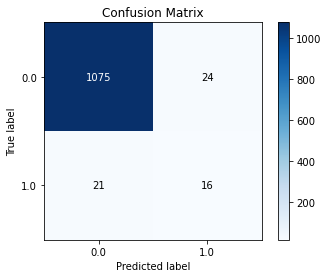

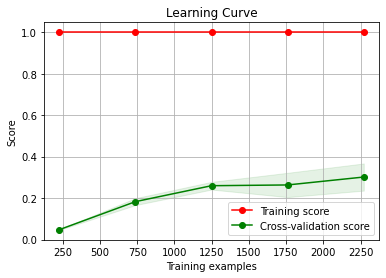

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.43061538689286616 0.033742663692361445


Weight,Feature
0.0540,cash_/_current_liability
0.0480,interest-bearing_debt_interest_rate
0.0424,roa(c)_before_tax_and_interest_before_depreciation
0.0335,total_income_/_total_expense
0.0334,continuous_profit_rate_(after_tax)
0.0321,retained_earnings/total_assets
0.0316,equity_to_long-term_liability
0.0292,accounts_receivable_turnover
0.0249,net_income_to_total_assets
0.0237,equipment_rate_per_person


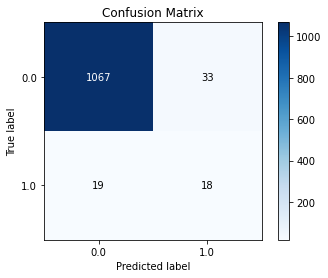

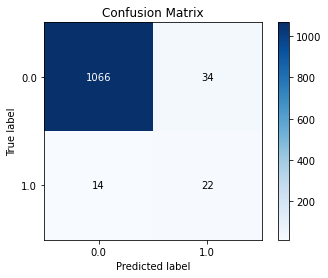

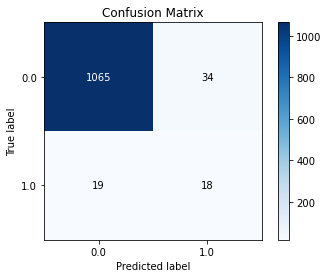

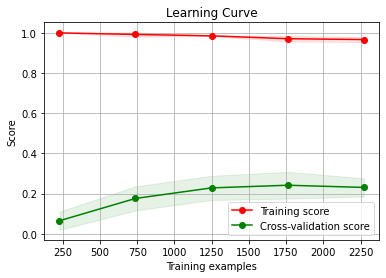

In [ ]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.464243955932228 0.03206665746593907


Weight,Feature
0.1248,continuous_profit_rate_(after_tax)
0.0881,book_value_per_share_(b)
0.0719,interest-bearing_debt_interest_rate
0.0577,borrowing_dependency
0.0439,net_worth_growth_rate
0.0337,cash_/_current_liability
0.0326,net_income_to_total_assets
0.0325,retained_earnings/total_assets
0.0245,average_collection_days
0.0215,total_assets_growth_rate_


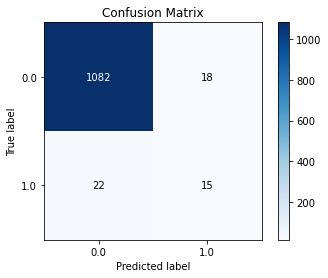

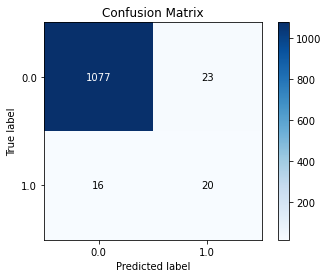

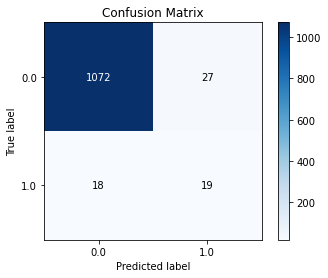

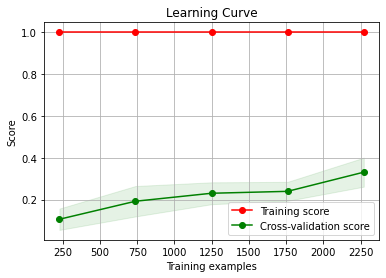

In [ ]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
make_experiment(model, threshold=0.1, show_cm=True)


#### Submit

In [ ]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
save_result("lgb_threshold_0.1.csv", model)

Saved:  ../output/lgb_threshold_0.1.csv


In [ ]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0)
save_result("ctb_threshold_0.1.csv", model)

Saved:  ../output/ctb_threshold_0.1.csv


#### Łączenie modeli 

(W praktyce łączymy wyniki tych modeli)

In [ ]:
xgb_output = pd.read_csv("../output/xgb_threshold_0.1.csv")
lgb_output = pd.read_csv("../output/lgb_threshold_0.1.csv")
ctb_output = pd.read_csv("../output/ctb_threshold_0.1.csv")

(0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]).value_counts()

0.00    3196
1.00      83
0.33      55
0.67      31
0.34      25
0.66      20
Name: target, dtype: int64

In [ ]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]
output["target"] = ((0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]) > 0.2).astype(np.int)

output.to_csv("../output/0.33xgb_0.34lgb_0.33ctb.csv", index=False)

#### Feature engineering

In [ ]:
df_all["risk_borr_depency"] = df_train["borrowing dependency"].map(lambda x: 1 if x >= 0.5 and x <= 1 else 0)
df_all['risk_PersistentEPS_Lfs'] = df_train['Persistent EPS in the last four seasons'].map(lambda x: 1 if x <= 0.25 else 0)
df_all['risk_BookValueB'] = df_train['Book value per share (B)'].map(lambda x: 1 if x >= 0.1 and x <= 0.21 else 0)
df_all['risk_NetWorthGrowthRate'] = df_train['Net worth growth rate'].map(lambda x: 1 if x >= 0.000093 and x <= 0.000871 else 0)
df_all['cash_flow-borrowing'] = (df_train["borrowing dependency"] < 0.5 ) & (df_train["borrowing dependency"] > 0.2 ) & (df_train['cash flow to liability'] < 0.5 ) & (df_train['cash flow to liability'] > 0.3427 )


In [ ]:
df_all['feature_cash'] = df_train[['cash / current liability', 'cash flow to liability', 'cash flow to equity']].sum(axis=1)

#df_all['feature_borrowing'] = df_train[['borrowing dependency', 'cash_flow-borrowing']].sum(axis=1)

df_all['feature_expense'] = df_train[[ 'Research and development expense ratio', 'Interest expense ratio', 
                                        'total income / total expense', 'total expense /assets', 
                                        'Interest coverage ratio( Interest expense to EBIT )' ]].sum(axis=1)


df_all['feature_profit'] = df_train[['Operating gross profit margin', 'Already Realized gross profit margin of sales', 
                                       'Operating profit rate', 'Net profit margin before tax',
                                       'Net profit margin after tax', 'Continuous profit rate (after tax)',
                                       'Operating profit per share (RMB)', 'Net profit per share before tax (Yuan)',
                                       'Realized sales gross profit growth rate', 'Operating profit growth rate', 
                                       'After-tax net profit growth rate', 'Regular net profit growth rate', 
                                       'Permanent net profit growth rate', 'operating profit/paid-in capital', 
                                       'pre-tax net profit/real income Capital', 'Operating profit per person', 
                                       'Gross profit to Sales']].sum(axis=1)

['roa(c)_before_tax_and_interest_before_depreciation', 'roa(a)_after_tax_and_before_interest%', 'roa(b)_after_tax_and_before_interest,_before_depreciation', 'operating_gross_profit_margin', 'already_realized_gross_profit_margin_of_sales', 'operating_profit_rate', 'net_profit_margin_before_tax', 'net_profit_margin_after_tax', 'non-industry_revenue_and_expenditure/revenue', 'continuous_profit_rate_(after_tax)', 'business_expense_rate', 'research_and_development_expense_ratio', 'cash_flow_ratio', 'interest-bearing_debt_interest_rate', 'tax_rate_(a)', 'book_value_per_share_(b)', 'book_value_per_share_(a)', 'book_value_per_share_(c)', 'persistent_eps_in_the_last_four_seasons', 'cash_flow_per_share', 'turnover_per_share_(rmb)', 'operating_profit_per_share_(rmb)', 'net_profit_per_share_before_tax_(yuan)', 'realized_sales_gross_profit_growth_rate', 'operating_profit_growth_rate', 'after-tax_net_profit_growth_rate', 'regular_net_profit_growth_rate', 'permanent_net_profit_growth_rate', 'total_as

Weight,Feature
0.0635,continuous_profit_rate_(after_tax)
0.0628,persistent_eps_in_the_last_four_seasons
0.0512,working_capital/equity
0.0394,feature_profit
0.0342,net_income_to_total_assets
0.0309,business_expense_rate
0.0261,total_debt/total_net_worth
0.0233,book_value_per_share_(b)
0.0232,roa(a)_after_tax_and_before_interest%
0.0224,net_worth_growth_rate


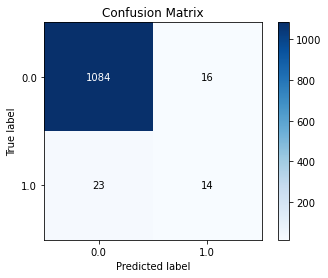

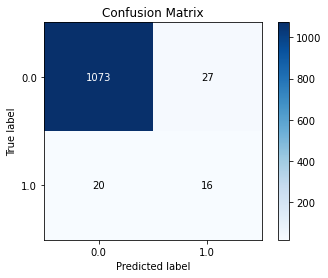

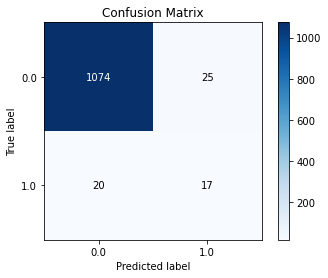

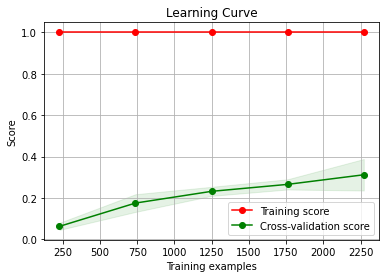

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True, show_feats=True)

<AxesSubplot:>

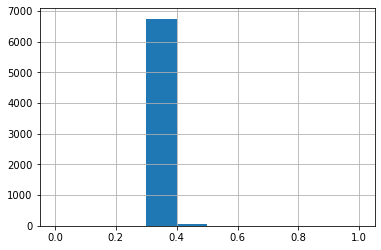

In [ ]:
df_all["borrowing_dependency"].hist()

In [ ]:
def my_hist(df_all, feat_name, left_perc=1, right_perc=99):
    min_value = np.percentile( df_all[feat_name], 1)
    max_value = np.percentile( df_all[feat_name], 99)

    (
        df_all[ 
            (df_all[feat_name] > min_value) &
            (df_all[feat_name] < max_value)
        ][feat_name]
    ).hist(bins=100)
    plt.title("{}\n, left_perc={}, right_perc={}".format(feat_name, left_perc, right_perc))
    plt.show()

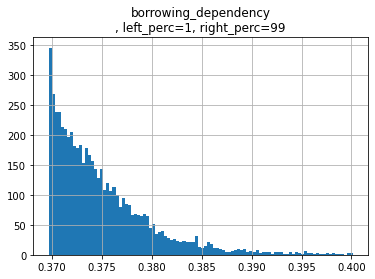

In [ ]:
my_hist(df_all, "borrowing_dependency");

In [ ]:
#df_train.columns

In [ ]:
df_train.columns = [x.replace(" ", "_").lower() for x in df_train.columns]

In [ ]:
pd.pivot_table(df_train, index=["target"], values=['borrowing_dependency'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,borrowing_dependency,borrowing_dependency,borrowing_dependency
target,,,
0,0.374027,0.187124,0.529443
1,0.390566,0.262035,1.000000


In [ ]:
feat_name = "borrowing_dependency"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = 0.376 #df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] > mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
borrowing_dependency_cut,,
0,2478,23
1,821,87


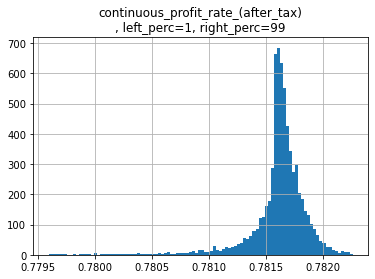

In [ ]:
my_hist(df_all, "continuous_profit_rate_(after_tax)");

In [ ]:
pd.pivot_table(df_train, index=["target"], values=['continuous_profit_rate_(after_tax)'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,continuous_profit_rate_(after_tax),continuous_profit_rate_(after_tax),continuous_profit_rate_(after_tax)
target,,,
0,0.781429,0.133479,1.000000
1,0.780974,0.772373,0.781813


In [ ]:
feat_name = "continuous_profit_rate_(after_tax)"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] > mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
continuous_profit_rate_(after_tax)_cut,,
0,176,37
1,3123,73


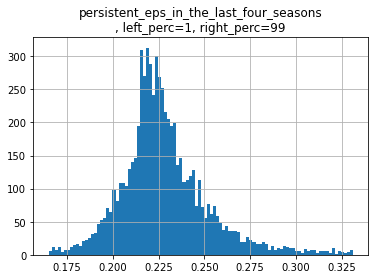

In [ ]:
my_hist(df_all, "persistent_eps_in_the_last_four_seasons");

In [ ]:
pd.pivot_table(df_train, index=["target"], values=['persistent_eps_in_the_last_four_seasons'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,persistent_eps_in_the_last_four_seasons,persistent_eps_in_the_last_four_seasons,persistent_eps_in_the_last_four_seasons
target,,,
0,0.229819,0.078567,1.000000
1,0.190774,0.000000,0.252529


In [ ]:
feat_name = "persistent_eps_in_the_last_four_seasons"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < 0.23).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
persistent_eps_in_the_last_four_seasons_cut,,
0,1286,2
1,2013,108


In [ ]:
pd.pivot_table(df_train, index=["target"], values=['working_capital/equity'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,working_capital/equity,working_capital/equity,working_capital/equity
target,,,
0,0.736169,0.665664,0.961070
1,0.729363,0.517571,0.825197


In [ ]:
feat_name = "working_capital/equity"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] > mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
working_capital/equity_cut,,
0,561,57
1,2738,53


In [ ]:
pd.pivot_table(df_train, index=["target"], values=['roa(a)_after_tax_and_before_interest%'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,roa(a)_after_tax_and_before_interest%,roa(a)_after_tax_and_before_interest%,roa(a)_after_tax_and_before_interest%
target,,,
0,0.561123,0.006923,0.984736
1,0.454040,0.000000,0.582861


In [ ]:
feat_name = "roa(a)_after_tax_and_before_interest%"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = 0.545  #df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
roa(a)_after_tax_and_before_interest%_cut,,
0,2226,15
1,1073,95


In [ ]:
pd.pivot_table(df_train, index=["target"], values=['roa(b)_after_tax_and_before_interest,_before_depreciation'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,"roa(b)_after_tax_and_before_interest,_before_depreciation","roa(b)_after_tax_and_before_interest,_before_depreciation","roa(b)_after_tax_and_before_interest,_before_depreciation"
target,,,
0,0.556012,0.000000,0.957760
1,0.462678,0.033514,0.619091


In [ ]:
feat_name = "roa(b)_after_tax_and_before_interest,_before_depreciation"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = 0.53 #df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
"roa(b)_after_tax_and_before_interest,_before_depreciation_cut",,
0,2458,17
1,841,93


In [ ]:
pd.pivot_table(df_train, index=["target"], values=['net_income_to_total_assets'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,net_income_to_total_assets,net_income_to_total_assets,net_income_to_total_assets
target,,,
0,0.80941,0.000000,1.000000
1,0.73570,0.411809,0.819091


In [ ]:
feat_name = "net_income_to_total_assets"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
net_income_to_total_assets_cut,,
0,2981,51
1,318,59


Score:  0.4177844952452925 0.010335783482047313


Weight,Feature
0.0635,continuous_profit_rate_(after_tax)
0.0628,persistent_eps_in_the_last_four_seasons
0.0512,working_capital/equity
0.0394,feature_profit
0.0342,net_income_to_total_assets
0.0309,business_expense_rate
0.0261,total_debt/total_net_worth
0.0233,book_value_per_share_(b)
0.0232,roa(a)_after_tax_and_before_interest%
0.0224,net_worth_growth_rate


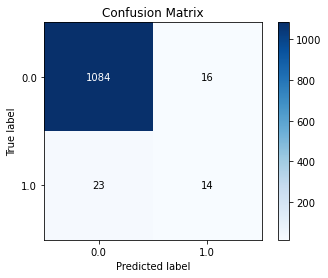

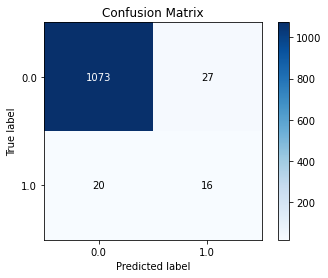

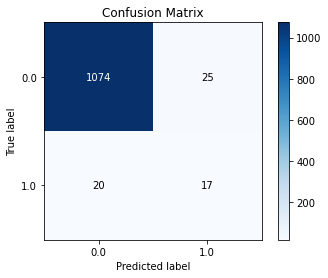

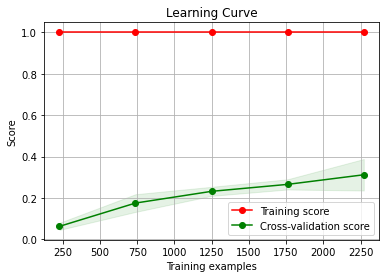

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.44488211864563 0.03442004937670027


Weight,Feature
0.1244,continuous_profit_rate_(after_tax)
0.0897,book_value_per_share_(b)
0.0688,interest-bearing_debt_interest_rate
0.0542,borrowing_dependency
0.0433,net_worth_growth_rate
0.0336,retained_earnings/total_assets
0.0334,cash_/_current_liability
0.0277,net_income_to_total_assets
0.0244,quick_asset/current_liabilities
0.0214,cash_/_total_assets


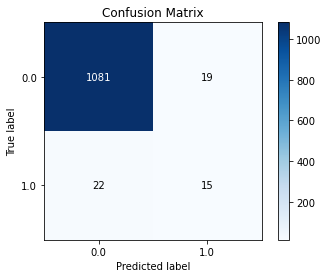

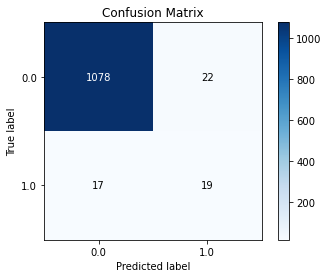

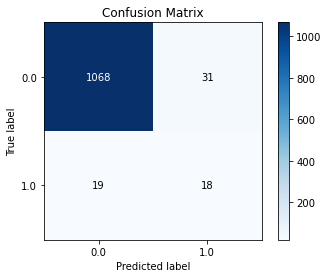

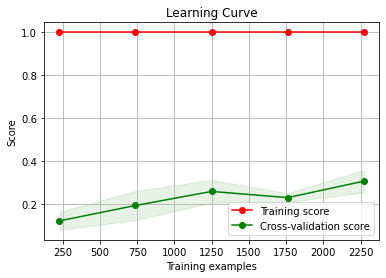

In [ ]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
make_experiment(model, threshold=0.1, show_cm=True)

In [ ]:
pd.pivot_table(df_train, index=["target"], values=['interest-bearing_debt_interest_rate'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,interest-bearing_debt_interest_rate,interest-bearing_debt_interest_rate,interest-bearing_debt_interest_rate
target,,,
0,0.001130,0.0,1.000000
1,0.000528,0.0,0.001086


In [ ]:
feat_name = "interest-bearing_debt_interest_rate"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = 0.00047 #df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] > mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
interest-bearing_debt_interest_rate_cut,,
0,2458,49
1,841,61


In [ ]:
pd.pivot_table(df_train, index=["target"], values=['net_worth_growth_rate'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,net_worth_growth_rate,net_worth_growth_rate,net_worth_growth_rate
target,,,
0,0.000576,0.000014,0.138678
1,0.000395,0.000093,0.000871


In [ ]:
feat_name = "net_worth_growth_rate"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = 0.00042  #df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
net_worth_growth_rate_cut,,
0,2925,41
1,374,69


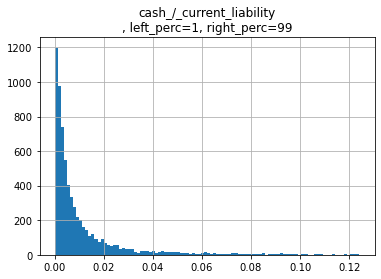

In [ ]:
my_hist(df_all, "cash_/_current_liability");

In [ ]:
pd.pivot_table(df_train, index=["target"], values=['cash_/_current_liability'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,cash_/_current_liability,cash_/_current_liability,cash_/_current_liability
target,,,
0,0.013238,0.000000,1.000000
1,0.002735,0.000004,0.036163


In [ ]:
feat_name = "cash_/_current_liability"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = 0.0015  #df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
cash_/_current_liability_cut,,
0,2677,38
1,622,72


In [ ]:
pd.pivot_table(df_train, index=["target"], values=['retained_earnings/total_assets'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,retained_earnings/total_assets,retained_earnings/total_assets,retained_earnings/total_assets
target,,,
0,0.935404,0.000000,0.998858
1,0.901380,0.745877,0.955245


In [ ]:
feat_name = "retained_earnings/total_assets"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
retained_earnings/total_assets_cut,,
0,2984,48
1,315,62


In [ ]:
pd.pivot_table(df_train, index=["target"], values=['turnover_per_share_(rmb)'], aggfunc=["mean", "min", "max"] )

,mean,min,max
,turnover_per_share_(rmb),turnover_per_share_(rmb),turnover_per_share_(rmb)
target,,,
0,0.039678,0.000000,1.000000
1,0.025546,0.000423,0.235976


In [ ]:
feat_name = "turnover_per_share_(rmb)"
df_group = df_train.groupby("target")[feat_name].agg(["mean", "std", "min", "max", "count"])
mean_cut = 0.024  #df_group["mean"].mean()
df_all["{}_cut".format(feat_name)] = (df_all[feat_name] < mean_cut).astype(np.int)
pd.crosstab(df_all[df_all.target.notnull()]["{}_cut".format(feat_name)], df_all[df_all.target.notnull()]["target"])

target,0.0,1.0
turnover_per_share_(rmb)_cut,,
0,1890,39
1,1409,71


Score:  0.4196237249326235 0.01264614855049932


Weight,Feature
0.0711,continuous_profit_rate_(after_tax)
0.0704,persistent_eps_in_the_last_four_seasons
0.0503,working_capital/equity
0.0442,feature_profit
0.0383,net_income_to_total_assets
0.0293,total_debt/total_net_worth
0.0262,book_value_per_share_(b)
0.0215,quick_asset/current_liabilities
0.0209,roa(c)_before_tax_and_interest_before_depreciation
0.0201,tax_rate_(a)


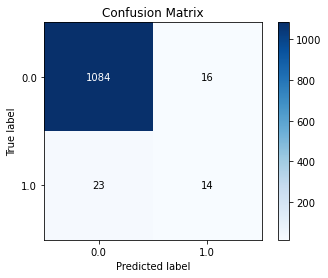

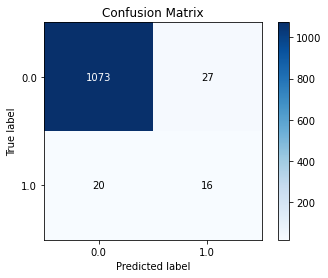

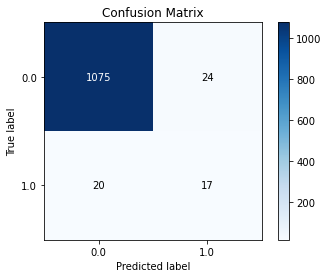

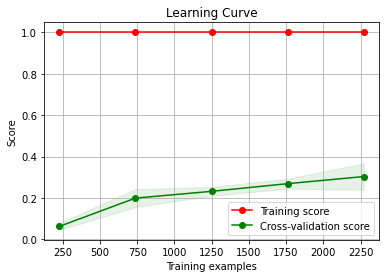

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=150, random_state=0)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.4551481593342059 0.0306054645630516


Weight,Feature
0.1244,continuous_profit_rate_(after_tax)
0.0897,book_value_per_share_(b)
0.0688,interest-bearing_debt_interest_rate
0.0542,borrowing_dependency
0.0433,net_worth_growth_rate
0.0336,retained_earnings/total_assets
0.0334,cash_/_current_liability
0.0277,net_income_to_total_assets
0.0244,quick_asset/current_liabilities
0.0214,cash_/_total_assets


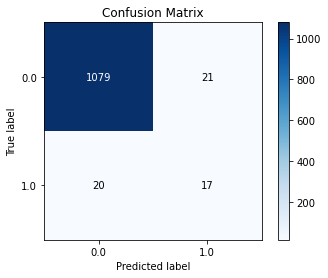

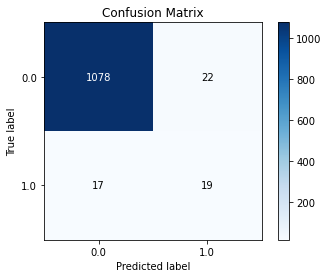

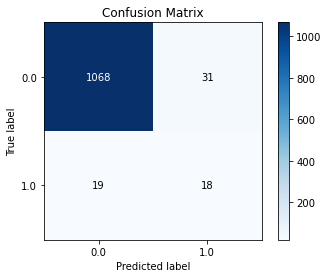

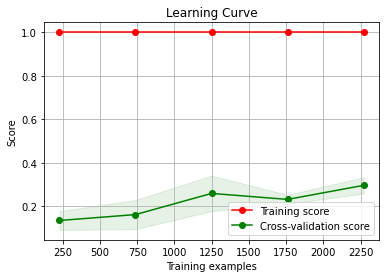

In [ ]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
make_experiment(model, threshold=0.1, show_cm=True)

Score:  0.48893387314439946 0.019490282032341127


Weight,Feature
0.0512,interest-bearing_debt_interest_rate
0.0424,roa(c)_before_tax_and_interest_before_depreciation
0.0404,net_profit_margin_before_tax
0.0353,equity_to_liability
0.0297,cash_flow_ratio
0.0231,net_income_to_stockholder's_equity
0.0230,operating_profit/paid-in_capital
0.0215,current_liability_to_assets
0.0208,cash_/_current_liability
0.0198,equity_to_long-term_liability


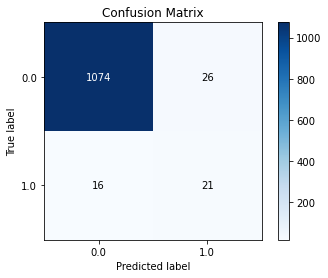

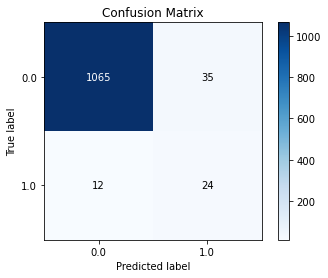

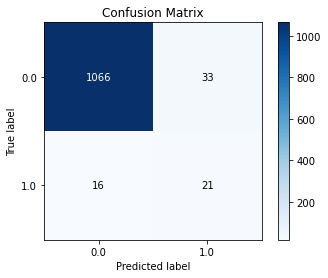

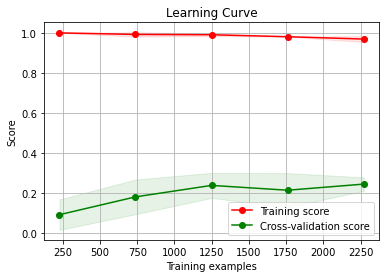

In [ ]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=200, verbose=0)
make_experiment(model, threshold=0.1, show_cm=True)

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=150, random_state=0)
save_result("xgb3_threshold_0.1.csv", model)

Saved:  ../output/xgb3_threshold_0.1.csv


In [ ]:
model = lgb.LGBMClassifier(max_depth=5, n_estimators=100)
save_result("lgbm3_threshold_0.1.csv", model)

Saved:  ../output/lgbm3_threshold_0.1.csv


In [ ]:
model = ctb.CatBoostClassifier(max_depth=5, n_estimators=200, verbose=0)
save_result("ctb3_threshold_0.1.csv", model)

Saved:  ../output/ctb3_threshold_0.1.csv


In [ ]:
# Łączenie modeli

xgb_output = pd.read_csv("../output/xgb3_threshold_0.1.csv")
lgb_output = pd.read_csv("../output/lgbm3_threshold_0.1.csv")
ctb_output = pd.read_csv("../output/ctb3_threshold_0.1.csv")

(0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]).value_counts()

0.00    3203
1.00      91
0.33      37
0.67      32
0.34      24
0.66      23
Name: target, dtype: int64

In [ ]:
output = pd.DataFrame()
output["id"] = xgb_output["id"]
output["target"] = ((0.33*xgb_output["target"] + 0.34*lgb_output["target"] + 0.33*ctb_output["target"]) > 0.2).astype(np.int)

output.to_csv("../output/0.33xgb3_0.34lgb3_0.33ctb3.csv", index=False)

# to rozwiązanie na Kaggle dało wynik 0.42682



Najlepszy wynik na Kaggle osiągnął model LGBMClassifier (0.49600 Public Leaderboard) 0.45454 (Private Leaderboard)